# Intro to Python Final Project: Delay Discounting Pilot Analysis 

In this notebook, I'm trying to compare two different versions of a Delay Discounting Task. One version, which here I call "binary", has already been validated in the [literature](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2014.00050/full). I am testing a new version, which I call "likert" (called this name because it has a likert scale).

My key aim is to **compare the outputs between "binary" and "likert"** to determine if my new likert task can be used in future studies. 

I will accomplish this primarily by using a logistic binary regression model on outputs from both tasks, and comparing the model outputs between the two tasks to see if they are similar.

## NOTE:

This notebook is run with an environment I created which I've named "discounting". To open and use this environment, follow these steps: 

1. Import `dicounting_environment.yml` (located in this repository) to a directory on your computer. 
2. Navigate to the same directory in your terminal, and create a new environment with the `dicounting_environment.yml` file, ie: 
    
    `conda env create -f discounting_environment.yml`
3. Install this environment as a kernel to use in VSCode or Jupyter Lab, ie:
    
    `conda activate discounting`
    
    `python -m ipykernel install --user --name=discounting --display-name "Python (discounting)"`
4. Find the `discounting` kernel in VSCode / Jupyter Lab.

## Relevant User Inputs (Modifiable)

These are all of the inputs needed to run this notebook.

In [1]:
## File paths & study names --------------------------------------------------------------------------------

# File path ('dataDir'): this is the path to the files we are reading in for analysis
dataDir = 'Processed_data' # Make sure the folder 'Processed_data' is in the same directory as this notebook, or change this directory to where 'Processed_data' is located

# List of studies, each with data files corresponding to individual participants' behavioral data
studies = [
    'delay_discounting_version7_2options_online_simplified/individual_participant_data',
    'delay_discounting_version7_Likert_online_simplified/individual_participant_data'
]


## Model parameters -----------------------------------------------------------------------------------------
V_LL = 50           # Larger later reward amount
V = 25              # Smaller sooner reward amount (defined here as "V") <- this is the reference value, i.e. the default that participants select of getting $25 immediately
max_subjects = 1000 # Maximum number of subjects expected

## Import Packages & Validate Inputs

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

# Validate inputs 
if not os.path.isdir(dataDir):
    raise FileNotFoundError(f"Data directory not found: {dataDir}")

if not isinstance(studies, list) or len(studies) == 0:
    raise ValueError("`studies` must be a non-empty list of folder names.")

if V_LL <= 0 or V <= 0:
    raise ValueError("Reward values must be positive numbers.")

# Required columns for each CSV
required_columns = {"delay", "amount", "rt", "key"} # expected columns in each CSV file

# validate study names contain expected keywords
valid_keywords = ["2options", "Likert"]
for study in studies: 
    if not any(keyword in study for keyword in valid_keywords):
        raise ValueError(
            f"Study folder {study} does not contain '2options or 'Likert'."
            "These keywords are required for study-specific logic later in the code."
        )

def validate_dataset_structure(dataDir, studies, required_columns):
    """
    Checks that each study folder contains CSV files 
    and that each CSV has the required columns.
    
    Raises:
        FileNotFoundError: if no files exist in a folder.
        ValueError: if any CSV is missing required columns.
    """
    for study in studies:
        folder_path = os.path.join(dataDir, study)
        files = glob.glob(os.path.join(folder_path, "*.csv"))

        # Check that CSVs exist
        if len(files) == 0:
            raise FileNotFoundError(f"No CSV files found in: {folder_path}")

        # Validate each file structure
        for f in files:
            df = pd.read_csv(f)
            missing = required_columns - set(df.columns)
            if missing:
                raise ValueError(
                    f"File '{f}' is missing required columns: {', '.join(missing)}"
                )
    return True

# Run validations before analysis
validate_dataset_structure(dataDir, studies, required_columns)
print("All inputs validated. Proceed with analysis.") # this runs only if the execution of validate_datset_structure() executes normally


All inputs validated. Proceed with analysis.


## Helper functions

These are all functions we are going to use to fit individuals' data to the model.

In [3]:
def negloglike(x, choices, delays, amounts, ss_amount):
    """
    Compute the negative log-likelihood for a binary logistic discounting model.

    The negative log-likelihood (NLL) is a measure of how well the model explains observed data (i.e., how probable the 
    observed data are given the model and its parameters).

    Low NLL: likelihood is high, the mdoel predicts the actual choices well.
    High NLL: likelihood is low, predictions are poor.

    Parameters
    ----------
    x : list or array
        Log parameters [log(k), log(beta)].
    choices : array
        Binary choices (0 = SS, 1 = LL).
    delays : array
        Delays associated with LL option.
    amounts : array
        Reward amounts for LL.
    ss_amount : float
        Fixed small-sooner reward value.

    Returns
    -------
    float
        Negative log-likelihood.
    """
    k = np.exp(x[0])
    beta = np.exp(x[1])
    SV_LL = amounts / (1 + k * delays)
    SV_SS = ss_amount
    p_LL = 1 / (1 + np.exp(-beta * (SV_LL - SV_SS))) # models choice behavior using a logistic choice rule
    p_LL = np.clip(p_LL, 1e-6, 1 - 1e-6)
    loglik = choices * np.log(p_LL) + (1 - choices) * np.log(1 - p_LL)
    return -np.sum(loglik)


def fit_discounting(choices, delays, amounts, ss_amount):
    """
    Fit a binary logistic discounting model with free parameters k and beta.

    This function minimizes the negative log-likelihood defined in `negloglike`,
    using BFGS minimization. Parameters are optimized in log-space and returned in linear space.

    Parameters
    ----------
    choices : array
        Binary choices (0 = SS, 1 = LL).
    delays : array
        Delays associated with LL options.
    amounts : array
        Reward amounts for LL options.
    ss_amount : float
        Fixed small-sooner reward value.

    Returns
    -------
    k_est : float
        Estimated discount rate k (exp-transformed from optimizer output).
    beta_est : float
        Estimated inverse temperature / slope parameter beta (exp-transformed).
    nll : float
        Final negative log-likelihood of the fitted model.
    """
    x0 = [np.log(0.01), np.log(1.0)]
    res = minimize(negloglike, x0, args=(choices, delays, amounts, ss_amount), # for linear: make minimizing linear 
                   method='BFGS')
    k_est, beta_est = np.exp(res.x)
    return k_est, beta_est, res.fun


def nll_k(x, choices, delays, amounts, ss_amount, beta):
    """
    Compute the negative log-likelihood of a binary discounting model where
    beta is fixed and only k is estimated.

    Parameters
    ----------
    x : list or array
        Log-transformed k parameter, [log(k)].
    choices : array
        Binary choices (0 = SS, 1 = LL).
    delays : array
        Delays for LL options.
    amounts : array
        Reward amounts for LL options.
    ss_amount : float
        Fixed small-sooner reward value.
    beta : float
        Fixed inverse temperature / slope parameter.

    Returns
    -------
    float
        Negative log-likelihood for the model with fixed beta.
    """

    k = np.exp(x[0])
    SV_LL = amounts / (1 + k * delays)
    diffSV = SV_LL - ss_amount
    z = np.clip(beta * diffSV, -700, 700)
    p = 1 / (1 + np.exp(-z))
    p = np.clip(p, 1e-8, 1 - 1e-8)
    return -np.sum(choices * np.log(p) + (1 - choices) * np.log(1 - p))



## Model fitting loop

This loops over individual studies and subjects within the specified data directory.

In [4]:
## Initialize storage

NLLs = np.full((len(studies), max_subjects), np.nan)    # Negative log-likelihoods per study x subject
Ks = np.full((len(studies), max_subjects), np.nan)      # Discount rates k   
rt_all = [[] for _ in studies]                          # Reaction times per study
all_choice_keys = []
all_dSV = []
all_RTs = []
subject_data = []


Skipping Processed_data/delay_discounting_version7_2options_online_simplified/individual_participant_data/098CCA7B6D0444D7B195569D94FB388C_processed_trialwise.csv — k_est=8.7541 out of range
Skipping Processed_data/delay_discounting_version7_2options_online_simplified/individual_participant_data/FD2A6686546A4D689BE4A684CD264636_processed_trialwise.csv — k_est=0.0000 out of range
Skipping Processed_data/delay_discounting_version7_2options_online_simplified/individual_participant_data/496DDD06DEFB45479BD534FDF4A48140_processed_trialwise.csv — k_est=11.3031 out of range
Skipping Processed_data/delay_discounting_version7_2options_online_simplified/individual_participant_data/B27D12A0E5074BA0B636F5FF79F39784_processed_trialwise.csv — k_est=9.4372 out of range
Skipping Processed_data/delay_discounting_version7_2options_online_simplified/individual_participant_data/DD44CA1228D0434495F8E152F1F7793D_processed_trialwise.csv — k_est=0.0000 out of range
Skipping Processed_data/delay_discounting_ve

/var/folders/xt/qs85nkk57c508r2jh9123qlh0000gn/T/ipykernel_26950/557756190.py:33: RuntimeWarning: overflow encountered in exp
  p_LL = 1 / (1 + np.exp(-beta * (SV_LL - SV_SS))) # models choice behavior using a logistic choice rule
/var/folders/xt/qs85nkk57c508r2jh9123qlh0000gn/T/ipykernel_26950/557756190.py:33: RuntimeWarning: overflow encountered in exp
  p_LL = 1 / (1 + np.exp(-beta * (SV_LL - SV_SS))) # models choice behavior using a logistic choice rule
/var/folders/xt/qs85nkk57c508r2jh9123qlh0000gn/T/ipykernel_26950/557756190.py:33: RuntimeWarning: overflow encountered in exp
  p_LL = 1 / (1 + np.exp(-beta * (SV_LL - SV_SS))) # models choice behavior using a logistic choice rule
/var/folders/xt/qs85nkk57c508r2jh9123qlh0000gn/T/ipykernel_26950/557756190.py:33: RuntimeWarning: overflow encountered in exp
  p_LL = 1 / (1 + np.exp(-beta * (SV_LL - SV_SS))) # models choice behavior using a logistic choice rule
/var/folders/xt/qs85nkk57c508r2jh9123qlh0000gn/T/ipykernel_26950/557756190.p

Skipping Processed_data/delay_discounting_version7_Likert_online_simplified/individual_participant_data/8B0A7B870B0243B1A3B69EFF69BD06EC_processed_trialwise.csv — k_est=0.0000 out of range
Skipping Processed_data/delay_discounting_version7_Likert_online_simplified/individual_participant_data/A9CEA77863774ACFAE514BF52A8485AE_processed_trialwise.csv — k_est=109.3528 out of range
Skipping Processed_data/delay_discounting_version7_Likert_online_simplified/individual_participant_data/1F9B17C1B86646F4AAA96705205F46AE_processed_trialwise.csv — k_est=47939014650.9079 out of range
Skipping Processed_data/delay_discounting_version7_Likert_online_simplified/individual_participant_data/67C755B1DA5740C58756E5FD16792FB3_processed_trialwise.csv — k_est=130.8471 out of range
Skipping Processed_data/delay_discounting_version7_Likert_online_simplified/individual_participant_data/578A4EC0A0C948ED96A7DF35DBECE4E7_processed_trialwise.csv — k_est=362639539444.0459 out of range
Skipping Processed_data/delay_

/var/folders/xt/qs85nkk57c508r2jh9123qlh0000gn/T/ipykernel_26950/557756190.py:33: RuntimeWarning: overflow encountered in exp
  p_LL = 1 / (1 + np.exp(-beta * (SV_LL - SV_SS))) # models choice behavior using a logistic choice rule
/var/folders/xt/qs85nkk57c508r2jh9123qlh0000gn/T/ipykernel_26950/557756190.py:33: RuntimeWarning: overflow encountered in exp
  p_LL = 1 / (1 + np.exp(-beta * (SV_LL - SV_SS))) # models choice behavior using a logistic choice rule
/var/folders/xt/qs85nkk57c508r2jh9123qlh0000gn/T/ipykernel_26950/557756190.py:33: RuntimeWarning: overflow encountered in exp
  p_LL = 1 / (1 + np.exp(-beta * (SV_LL - SV_SS))) # models choice behavior using a logistic choice rule


<Figure size 1000x400 with 0 Axes>

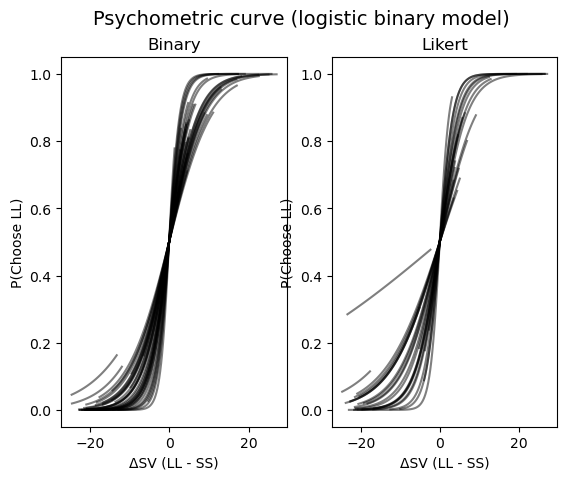

In [5]:

plt.figure(3, figsize=(10, 4)) # Figure for psychometric curves

# ----------------------
# Main analysis loop
# ----------------------
for stI, study in enumerate(studies):
    
    files = glob.glob(os.path.join(dataDir, study, "*.csv")) # inputs subject files for the relevant study
    if len(files) == 0:
        raise FileNotFoundError(f"No CSV files found in: {os.path.join(dataDir, study)}")

    for subI, f in enumerate(files):
        dat = pd.read_csv(f)
        D = dat["delay"].values
        A = dat["amount"].values
        RT = dat["rt"].values
        choice_key = dat["key"].values

        # ---- apply Boolean mask (T/F): keep rows with non-NaN key, delay, amount ----
        mask = (~np.isnan(choice_key) & ~np.isnan(D) & ~np.isnan(A)) 
        if not np.any(mask):
            print(f"Skipping {f} — all NaN or invalid data")
            continue

        choice_key, D, A, RT = choice_key[mask], D[mask], A[mask], RT[mask]

        # Convert raw responses to binary choices (0 = SS, 1 = LL)
        if "2options" in study:
            choices = (choice_key == 2).astype(float) # choice == 2 = LL option; converted to 1
        else:  # converts likert choices to binary choices
            choices = (choice_key > 3).astype(float) # choice > 3 = LL option; converted to 1


        
        k_est, beta, nll = fit_discounting(choices, D, A, V)

        # skip extreme k values
        if (k_est > 1) or (k_est < 0.0001):
            print(f"Skipping {f} — k_est={k_est:.4f} out of range")
            continue

        # Save per-subject data for Likert studies
        if "2options" not in study and (0.0001 <= k_est <= 1):
            SV_LL = A / (1 + k_est * D)
            SV_SS = V
            dSV = SV_LL - SV_SS
            
            # Only include trials with valid choice_key (not NaN)
            mask_valid = ~np.isnan(choice_key)
            all_choice_keys.extend(choice_key[mask_valid].tolist())
            all_dSV.extend(dSV[mask_valid].tolist())
            all_RTs.extend(RT[mask_valid].tolist())
            subject_data.append({
                "choices": choice_key.copy(),
                "RTs": RT.copy()
            })

        # Save model results 
        NLLs[stI, subI] = nll
        Ks[stI, subI] = k_est
        rt_all[stI].extend(RT.tolist())

        # Plot Psychometric curve (1 line = 1 subject)
        SV_LL = A / (1 + k_est * D)
        SV_SS = V
        dSV = SV_LL - SV_SS
        dSV_line = np.linspace(np.min(dSV), np.max(dSV), 100)
        p_pred_fv = 1 / (1 + np.exp(-beta * dSV_line))


        plt.figure(2)
        plt.subplot(1, 2, stI + 1)
        plt.plot(dSV_line, p_pred_fv, color="k", alpha=0.5)
        plt.xlabel("ΔSV (LL - SS)")
        plt.ylabel("P(Choose LL)")
        plt.suptitle("Psychometric curve (logistic binary model)",fontsize=14) # x=0.4
        plt.title("Binary" if "2options" in study else "Likert")



Based on this output (the psychometric curve), it appears that the model outputs are quite similar between the binary and likert task. 

Let's plot a few other aspects of the model / participants' behavior to see if they are similar in other ways.

## Other Model/Behavior Plots

### Reaction Time

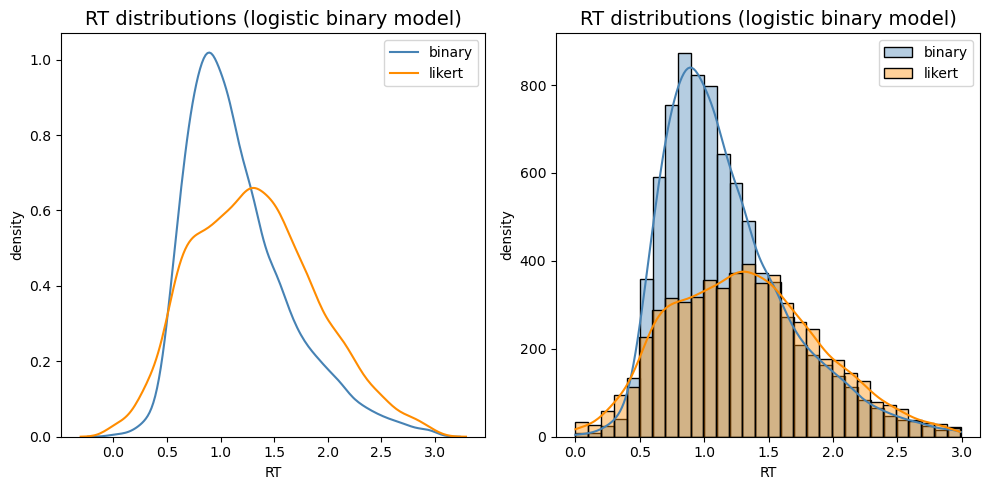

In [6]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
color = "steelblue" if "2options" in study else "darkorange"
sns.kdeplot(rt_all[0], color="steelblue", label="binary")
sns.kdeplot(rt_all[1], color="darkorange", label="likert")
plt.xlabel("RT")
plt.ylabel("density")
plt.title("RT distributions (logistic binary model)",fontsize=14) 
plt.legend()
plt.tight_layout() # automatically adjusts subplot spacing to prevent overlap


plt.subplot(1,2,2)
color = "steelblue" if "2options" in study else "darkorange"
sns.histplot(rt_all[0], bins=30, color="steelblue", label="binary", alpha=0.4, kde=True)
sns.histplot(rt_all[1], bins=30, color="darkorange", label="likert", alpha=0.4, kde=True)
plt.xlabel("RT")
plt.ylabel("density")
plt.title("RT distributions (logistic binary model)",fontsize=14) 
plt.legend()
plt.tight_layout() # automatically adjusts subplot spacing to prevent overlap


Both tasks have a similar peak at around an RT of 1.0 - 1.5.

### Subjective Value Curves

These are to plot participants' subjective value, i.e., how the perceived value of a delayed reward ($50) decreases as the delay increases, according to a hyperbolic disconting model.

/var/folders/xt/qs85nkk57c508r2jh9123qlh0000gn/T/ipykernel_26950/416106059.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10")(np.arange(2)) # color map for plots


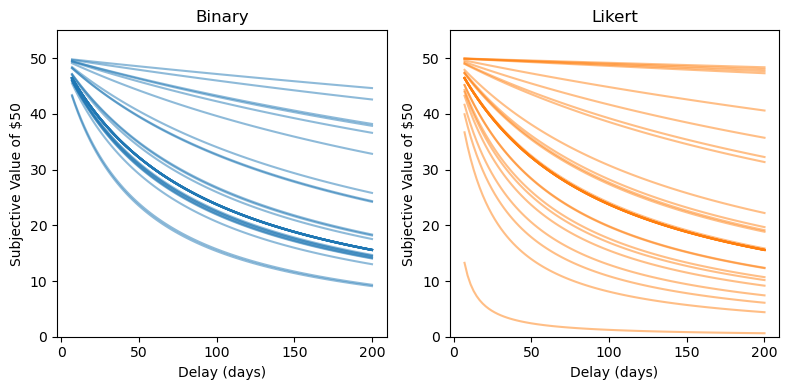

In [7]:
colors = plt.cm.get_cmap("tab10")(np.arange(2)) # color map for plots
plt.figure(3, figsize=(8, 4))

for stI, study in enumerate(studies):
    files = glob.glob(os.path.join(dataDir, study, "*.csv"))

    plt.subplot(1, 2, stI + 1)
    
    for subI, f in enumerate(files):
        dat = pd.read_csv(f)
        D = dat["delay"].values
        A = dat["amount"].values
        RT = dat["rt"].values
        choice_key = dat["key"].values
        choices = (choice_key ==2).astype(float) if "2options" in study else (choice_key >3).astype(float)

        mask = (~np.isnan(choices) & ~np.isnan(D) & ~np.isnan(A) & (choice_key != 3))
        if not np.any(mask):
            continue

        choices, D, A, RT, choice_key = choices[mask], D[mask], A[mask], RT[mask], choice_key[mask]

        k_est, beta, nll = fit_discounting(choices, D, A, V_LL)

        if (k_est > 1) or (k_est < 0.0001):
            continue

        # Plot hyperbolic subjective value curve
        D_range = np.linspace(np.min(D), np.max(D), 100)
        SV_curve = V_LL / (1 + k_est * D_range)
        plt.plot(D_range, SV_curve, color=colors[stI], alpha=0.5)

    plt.xlabel("Delay (days)")
    plt.ylabel("Subjective Value of $50")
    plt.title("Binary" if "2options" in study else "Likert")
    plt.ylim(0, V_LL * 1.1)  # keep y-axis consistent across subplots

plt.tight_layout()
plt.show()


Participants' subjective value appears to decrease at a similar rate over time, although there is more variance in the likert task.

### K & NLL distributions

In [8]:
# prepare masks for binary vs. likert 
Ks_flat = Ks.flatten()
NLLs_flat = NLLs.flatten()

# Identify which studies are binary vs. likert
binary_idx = [i for i, s in enumerate(studies) if "2options" in s]
likert_idx = [i for i, s in enumerate(studies) if "2options" not in s]

#### K distributions

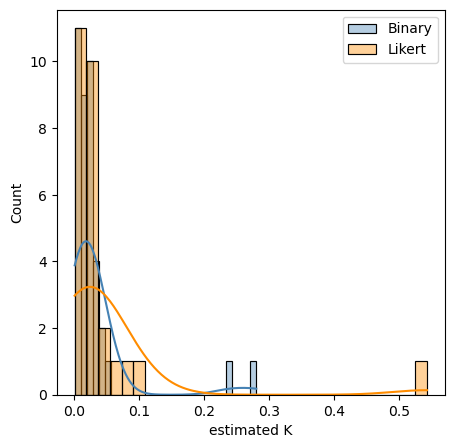

In [9]:
plt.figure(4, figsize=(5,5))

for idx in binary_idx:
    vals = Ks[idx, :]
    vals = vals[~np.isnan(vals)]
    if len(vals) > 0:
        sns.histplot(vals, bins=30, label="Binary", color="steelblue", alpha=0.4, kde=True)
        #sns.kdeplot(vals, label="Binary", color="steelblue", common_norm=False)

for idx in likert_idx:
    vals = Ks[idx, :]
    vals = vals[~np.isnan(vals)]
    if len(vals) > 0:
        sns.histplot(vals, bins=30, label="Likert", color="darkorange", alpha=0.4, kde=True)
        #sns.kdeplot(vals,label="Likert", color="darkorange", common_norm=False)
        
plt.xlabel("estimated K")
plt.legend()

The K estimates have similar peaks between both tasks.

#### NLL distributions 

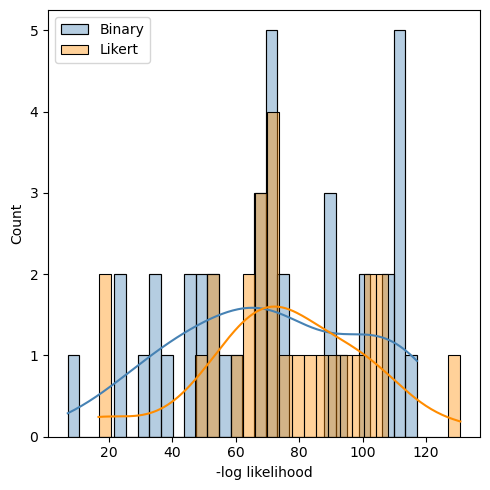

In [10]:
plt.figure(5, figsize=(5,5))

for idx in binary_idx:
    vals = NLLs[idx, :]
    vals = vals[~np.isnan(vals)]
    if len(vals) > 0:
        sns.histplot(vals, bins=30, color="steelblue", alpha=0.4, kde=True, label="Binary")
        #plt.hist(vals, bins=30, density=True, alpha=0.4, label="Binary", histtype="step", linewidth=2, color="blue")

for idx in likert_idx:
    vals = NLLs[idx, :]
    vals = vals[~np.isnan(vals)]
    if len(vals) > 0:
        sns.histplot(vals, bins=30, color="darkorange", alpha=0.4, kde=True, label="Likert")
        #plt.hist(vals, bins=30, density=True, alpha=0.4, label="Likert", histtype="step", linewidth=2, color="red")

plt.xlabel("-log likelihood")
plt.legend()

plt.tight_layout()
plt.show()

The NLLs also appear to be similarly distributed across both tasks. 